## Configuring the workspace
Assicurarsi di aver installato tutti le librerie necessarie per eseguire gli script all'interno del notebook

In [322]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Creo la cartella data per salvare i dataset
if not os.path.exists("data"):
    os.makedirs("data")

In [323]:
# Test ADF
def test_ADF(series):
    result = adfuller(series)
    print(f'Statistica del test ADF: {result[0]}')
    print(f'P-value: {result[1]}')
    print('Critical Values:')
    for thres, adf_stat in result[4].items():
        print('\t%s: %.2f' % (thres, adf_stat))

    if result[1] < 0.05:
        print("La serie è stazionaria")
    else:
        print("La serie non è stazionaria")

# Time Series


In [324]:
name_file="data/GOOG.csv"
if not os.path.exists(name_file):
    # Download the dataset
    !kaggle datasets download -d mbsoroush/google-dataset -p data
    !unzip data/google-dataset.zip -d data

In [325]:
df_data = pd.read_csv(name_file)

In [326]:
df_data.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,GOOG,2016-06-14 00:00:00+00:00,718.27,722.47,713.1200,716.48,1306065,718.27,722.47,713.1200,716.48,1306065,0.0,1.0
1,GOOG,2016-06-15 00:00:00+00:00,718.92,722.98,717.3100,719.00,1214517,718.92,722.98,717.3100,719.00,1214517,0.0,1.0
2,GOOG,2016-06-16 00:00:00+00:00,710.36,716.65,703.2600,714.91,1982471,710.36,716.65,703.2600,714.91,1982471,0.0,1.0
3,GOOG,2016-06-17 00:00:00+00:00,691.72,708.82,688.4515,708.65,3402357,691.72,708.82,688.4515,708.65,3402357,0.0,1.0
4,GOOG,2016-06-20 00:00:00+00:00,693.71,702.48,693.4100,698.77,2082538,693.71,702.48,693.4100,698.77,2082538,0.0,1.0


In [327]:
column_considered="close"
df_data = df_data[['date', column_considered]]
df_data.head()

,date,close
0,2016-06-14 00:00:00+00:00,718.27
1,2016-06-15 00:00:00+00:00,718.92
2,2016-06-16 00:00:00+00:00,710.36
3,2016-06-17 00:00:00+00:00,691.72
4,2016-06-20 00:00:00+00:00,693.71


# Gestione valori mancanti

In [328]:
print(f"Intervallo temporale: da {df_data['date'].min()} fino a {df_data['date'].max()}")

Intervallo temporale: da 2016-06-14 00:00:00+00:00 fino a 2021-06-11 00:00:00+00:00


In [329]:
df = pd.DataFrame(index=pd.date_range(start=df_data['date'].min(), end=df_data['date'].max(), freq='D'))

In [330]:
date_time_index= pd.DatetimeIndex(df_data['date'])
df_data.set_index(date_time_index,inplace=True)
df_data.drop('date',axis=1,inplace=True)

In [331]:
df = df.merge(df_data, how='left', left_index=True, right_index=True)

In [332]:
df.isna().sum()

close    566
dtype: int64

<Axes: >

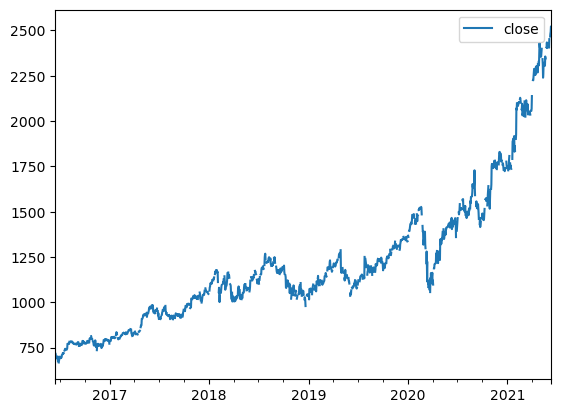

In [333]:
df.plot()

In [334]:
df[column_considered]=df[column_considered].interpolate(method='linear',axis=0, limit=None, inplace=False, limit_direction=None)

<Axes: >

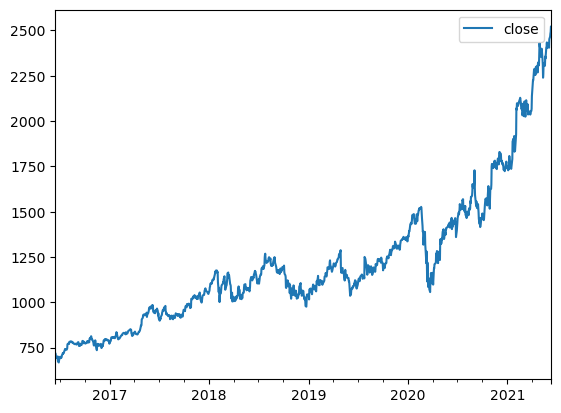

In [335]:
df.plot()

# Analisi serie temporale
Utilizzando le tecniche di rolling window normale ed esponenziale notiamo che la serie sembra presentare una tendenza esponenziale o polinomiale, ma nessuna stagionalità.


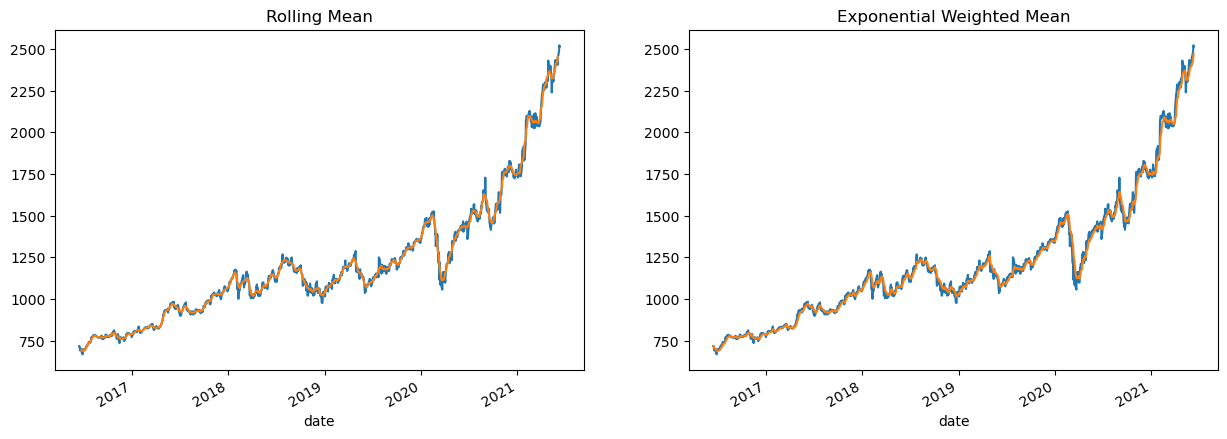

In [336]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))

df_data[column_considered].plot(ax=ax[0])
df_data[column_considered].rolling(12,center=True).mean().plot(ax=ax[0])
ax[0].set_title("Rolling Mean")

df_data[column_considered].plot(ax=ax[1])
df_data[column_considered].ewm(alpha=0.2,adjust=True).mean().plot(ax=ax[1])
ax[1].set_title("Exponential Weighted Mean")
plt.show()

Il correlogramma mostra una decrescenza all'aumentare dei lag, ciò indica la presenza di una tendenza

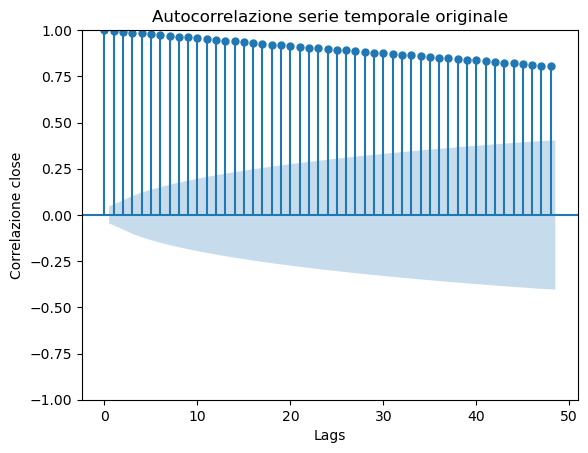

In [337]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df[column_considered],lags=48)
plt.title("Autocorrelazione serie temporale originale")
plt.ylabel(f"Correlazione {column_considered}")
plt.xlabel("Lags")
plt.show()

Text(0.5, 1.0, 'Decomposizione modello moltiplicativo')

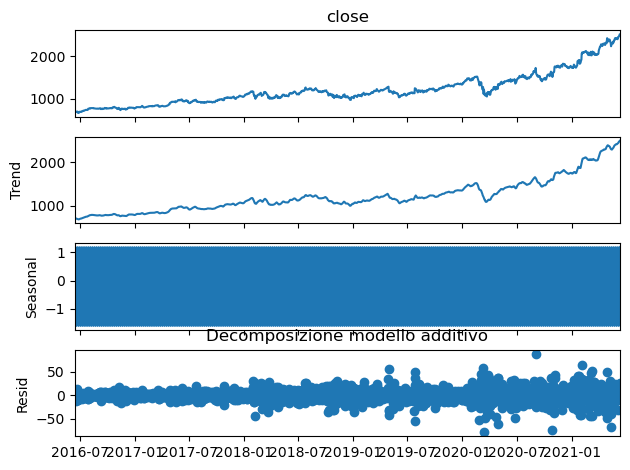

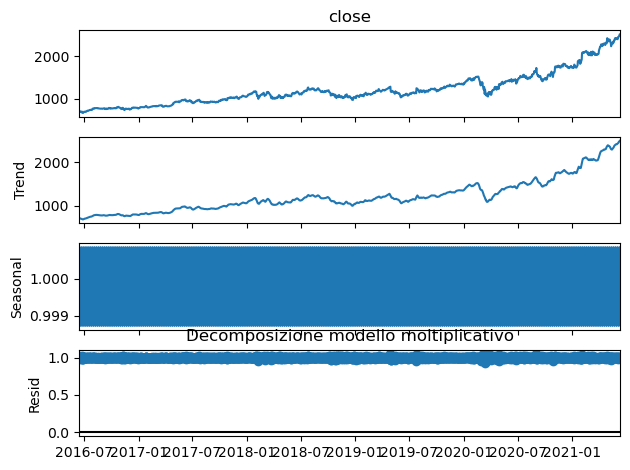

In [338]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition_multiplicative = seasonal_decompose(df[column_considered],model='multiplicative',extrapolate_trend='freq')
decomposition_additive = seasonal_decompose(df[column_considered],model='additive',extrapolate_trend='freq')

decomposition_additive.plot()
plt.title("Decomposizione modello additivo")

decomposition_multiplicative.plot()
plt.title("Decomposizione modello moltiplicativo")

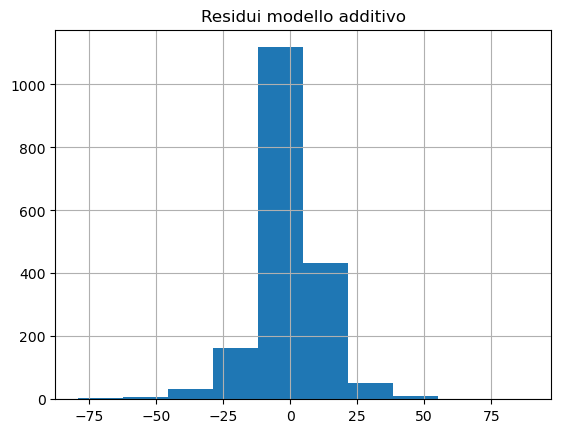

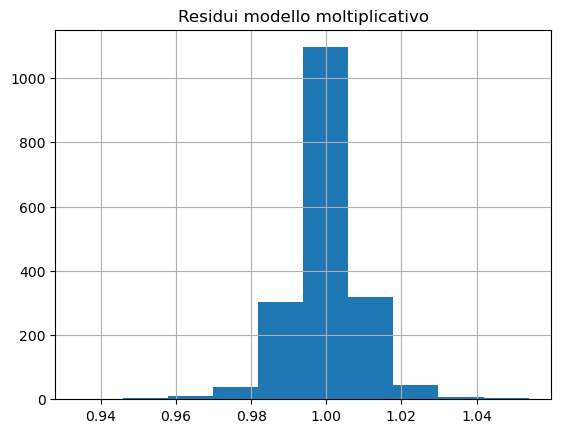

In [339]:
decomposition_additive.resid.hist()
plt.title("Residui modello additivo")
plt.show()

decomposition_multiplicative.resid.hist()
plt.title("Residui modello moltiplicativo")
plt.show()

In [340]:
print("Test ADF residui modello additivo")
test_ADF(decomposition_additive.resid.fillna(0))
print("Test ADF residui modello moltiplicativo")
test_ADF(decomposition_multiplicative.resid.fillna(0))

Test ADF residui modello additivo
Statistica del test ADF: -14.802130381468489
P-value: 2.0917002612875932e-27
Critical Values:
	1%: -3.43
	5%: -2.86
	10%: -2.57
La serie è stazionaria
Test ADF residui modello moltiplicativo
Statistica del test ADF: -15.613624092196911
P-value: 1.7671835111334999e-28
Critical Values:
	1%: -3.43
	5%: -2.86
	10%: -2.57
La serie è stazionaria


In [341]:
from scipy.stats import boxcox
# Trasformiamo il modello moltiplicativo in additivo
df[f'log_{column_considered}']=np.log(df[column_considered])
df[f"box_{column_considered}"], lmbda = boxcox(df[column_considered])

Text(0.5, 1.0, 'Decomposizione modello box-cox')

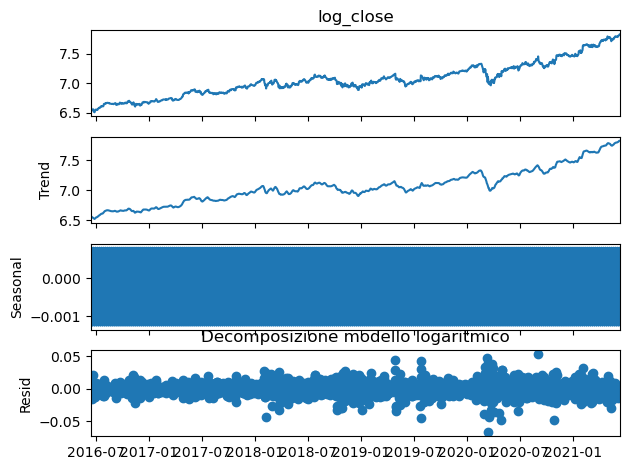

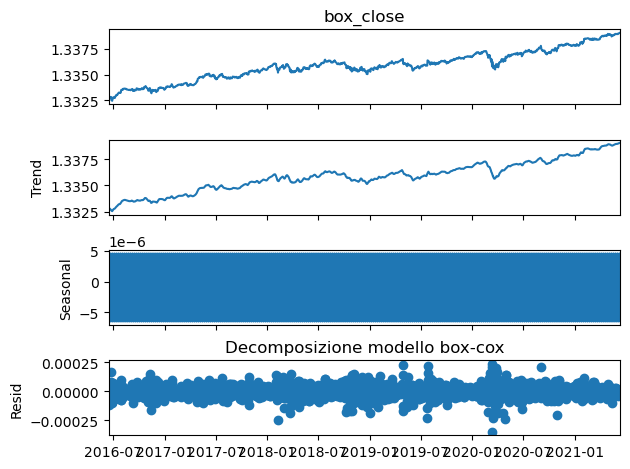

In [342]:
decomposition_log = seasonal_decompose(df[f'log_{column_considered}'],model='additive')
decomposition_box = seasonal_decompose(df[f"box_{column_considered}"],model='additive')

decomposition_log.plot()
plt.title("Decomposizione modello logaritmico")

decomposition_box.plot()
plt.title("Decomposizione modello box-cox")

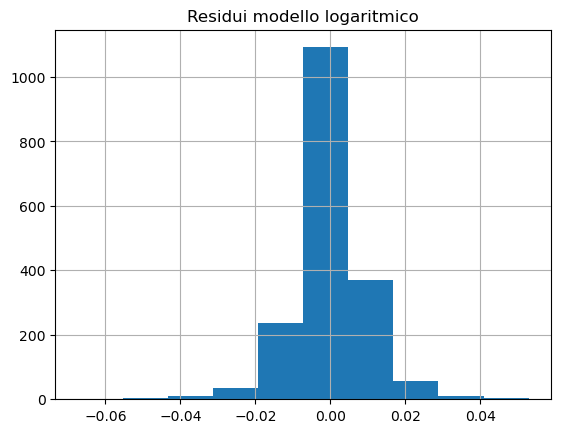

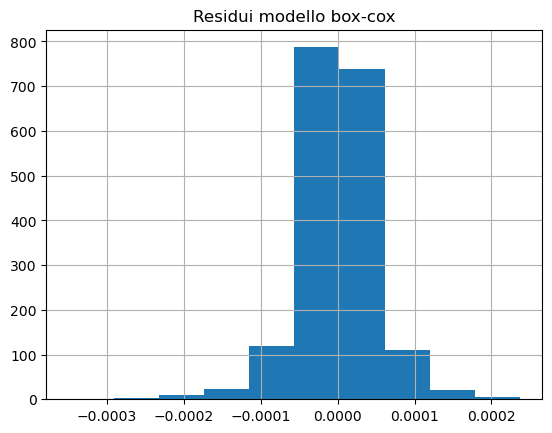

In [343]:
decomposition_log.resid.hist()
plt.title("Residui modello logaritmico")
plt.show()

decomposition_box.resid.hist()
plt.title("Residui modello box-cox")
plt.show()

Text(0.5, 1.0, 'Box Cox')

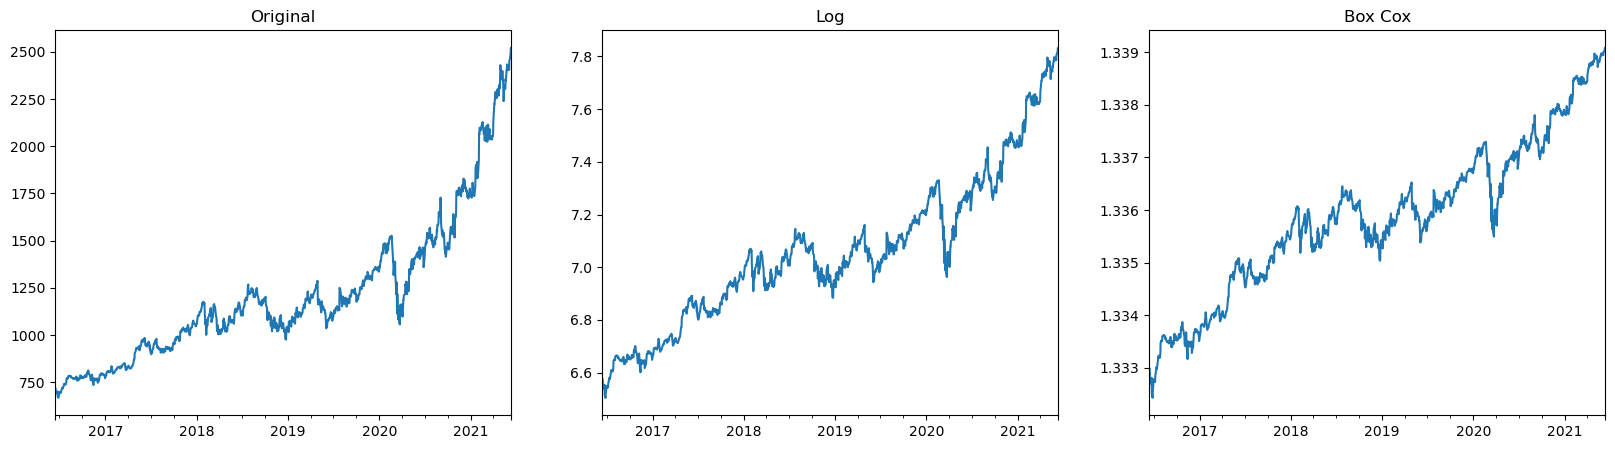

In [344]:
fig, ax = plt.subplots(1,3, figsize=(20, 5))

df[column_considered].plot(ax=ax[0])
ax[0].set_title("Original")

df[f'log_{column_considered}'].plot(ax=ax[1])
ax[1].set_title("Log")

df[f"box_{column_considered}"].plot(ax=ax[2])
ax[2].set_title("Box Cox")

In [345]:
print("Test ADF per la serie originale")
test_ADF(df[column_considered])
print("\nTest ADF per la serie logaritmica")
test_ADF(df[f'log_{column_considered}'])
print("\nTest ADF per la serie box-cox")
test_ADF(df[f'box_{column_considered}'])

Test ADF per la serie originale
Statistica del test ADF: 1.7058752124429593
P-value: 0.9981428653811442
Critical Values:
	1%: -3.43
	5%: -2.86
	10%: -2.57
La serie non è stazionaria

Test ADF per la serie logaritmica
Statistica del test ADF: -0.042596440345064636
P-value: 0.9548643954151226
Critical Values:
	1%: -3.43
	5%: -2.86
	10%: -2.57
La serie non è stazionaria

Test ADF per la serie box-cox
Statistica del test ADF: -1.1527542598716674
P-value: 0.6935825608058379
Critical Values:
	1%: -3.43
	5%: -2.86
	10%: -2.57
La serie non è stazionaria


# Modello di regressione

In [346]:
import statsmodels.api as sm
test_set_size = int(df.shape[0]*0.10)

Y_train = df[column_considered][:-test_set_size]
Y_train.reset_index(drop=True,inplace=True)
df["time"] = range(df.shape[0])
X_train = df["time"][:-test_set_size]
X_train = sm.add_constant(X_train)
X_train.reset_index(drop=True,inplace=True)

Y_test = df[column_considered][-test_set_size:]
Y_test.reset_index(drop=True,inplace=True)
X_test = df["time"][-test_set_size:]
X_test = sm.add_constant(X_test)
X_test.reset_index(drop=True,inplace=True)

model = sm.OLS(Y_train,X_train)
results = model.fit()

In [347]:
X_train

,const,time
0,1.0,0
1,1.0,1
2,1.0,2
3,1.0,3
4,1.0,4
...,...,...
1637,1.0,1637
1638,1.0,1638
1639,1.0,1639
1640,1.0,1640


In [348]:
np.arange(test_set_size,test_set_size + Y_test.shape[0])

array([182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194,
       195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207,
       208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,
       221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
       234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246,
       247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259,
       260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272,
       273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285,
       286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298,
       299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311,
       312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324,
       325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337,
       338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350,
       351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 36

<Axes: xlabel='None', ylabel='close'>

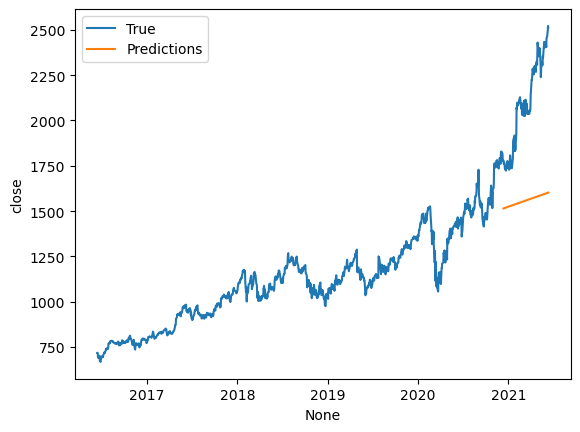

In [349]:
predictions = results.predict(X_test)
sns.lineplot(data=df[column_considered],label="True")
sns.lineplot(x=df.iloc[-test_set_size:].index,y=predictions,label="Predictions")

<Axes: >

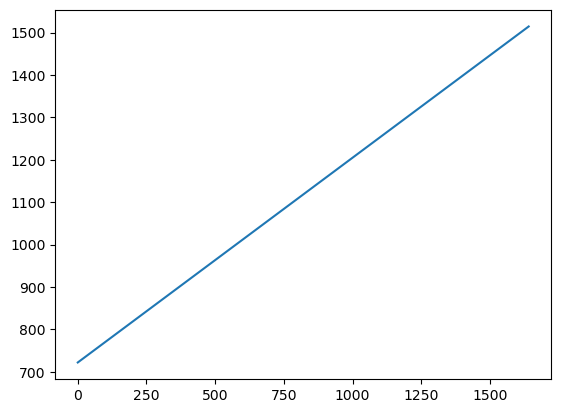

In [350]:
results.predict(X_train).plot()

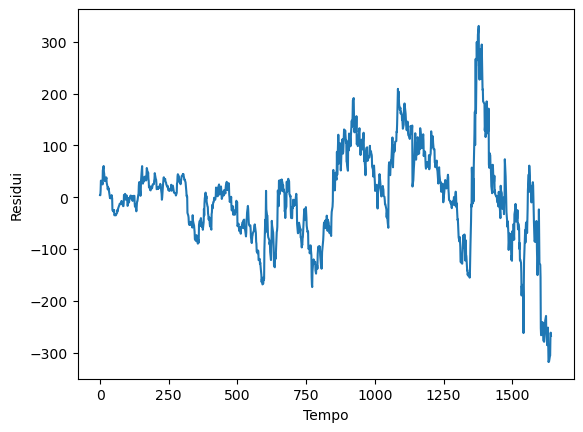

In [351]:
residuals = (results.predict(X_train) - Y_train)
plt.plot(residuals)
plt.xlabel('Tempo')
plt.ylabel('Residui')
plt.show()

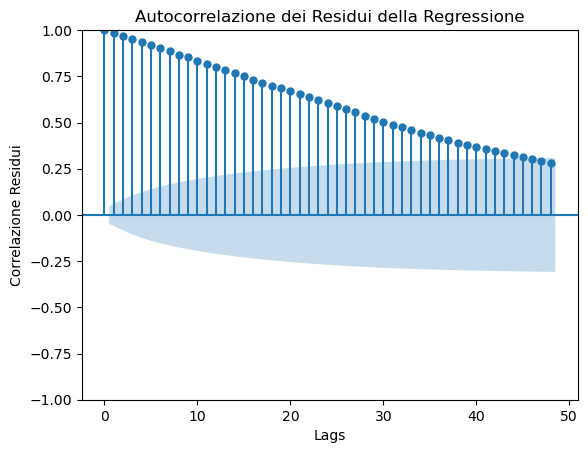

In [352]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=48)
plt.ylabel('Correlazione Residui')
plt.xlabel('Lags')
plt.title('Autocorrelazione dei Residui della Regressione')
plt.show()

# Rimuoviamo la tendenza

Text(0.5, 1.0, 'Differenza di ordine 2')

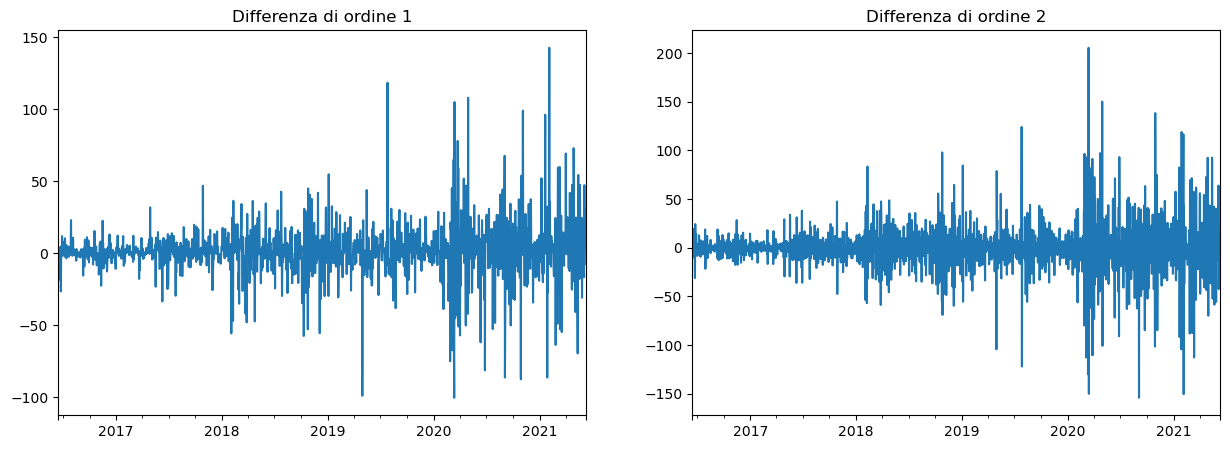

In [353]:
df[f"dif_1_{column_considered}"] = df[column_considered].diff().fillna(0)
df[f"dif_2_{column_considered}"] = df[f"dif_1_{column_considered}"].diff().fillna(0)


fig, ax = plt.subplots(1,2, figsize=(15, 5))

df[f"dif_1_{column_considered}"].plot(ax=ax[0])
ax[0].set_title("Differenza di ordine 1")

df[f"dif_2_{column_considered}"].plot(ax=ax[1])
ax[1].set_title("Differenza di ordine 2")

In [354]:
print("\nTest ADF per la serie differenziata 1 volta")
test_ADF(df[f"dif_1_{column_considered}"])
print("\nTest ADF per la serie differenziata 2 volte")
test_ADF(df[f"dif_2_{column_considered}"])



Test ADF per la serie differenziata 1 volta
Statistica del test ADF: -43.70509218594167
P-value: 0.0
Critical Values:
	1%: -3.43
	5%: -2.86
	10%: -2.57
La serie è stazionaria

Test ADF per la serie differenziata 2 volte
Statistica del test ADF: -15.503021664780698
P-value: 2.4020376409443595e-28
Critical Values:
	1%: -3.43
	5%: -2.86
	10%: -2.57
La serie è stazionaria


Text(0.5, 1.0, 'Autocorrelazione serie differenziata 1 volta')

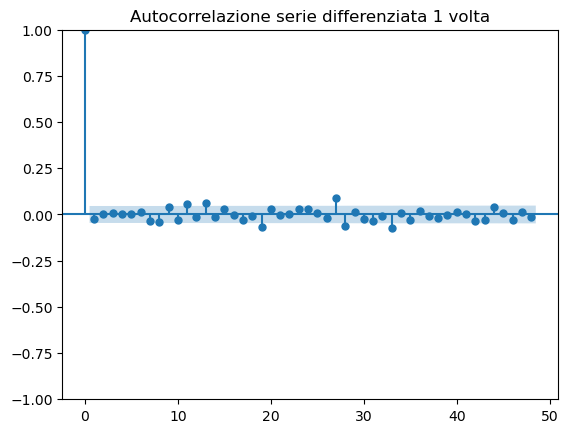

In [355]:
plot_acf(df[f"dif_1_{column_considered}"],lags=48)
plt.title("Autocorrelazione serie differenziata 1 volta")

In [356]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
train = df.iloc[:-test_set_size]
test = df.iloc[-test_set_size:]

selector = ar_select_order(train[f"dif_1_{column_considered}"].dropna(), maxlag=12)
model = AutoReg(train[f"dif_1_{column_considered}"].dropna(), lags=selector.ar_lags).fit()

In [357]:
results = model.forecast(steps=len(test))

In [358]:
test['forecast'] = results

/var/folders/x5/xvsgcbj13_s9tdm6w_4zqg9m0000gn/T/ipykernel_75196/1644803246.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['forecast'] = results


<Axes: ylabel='close'>

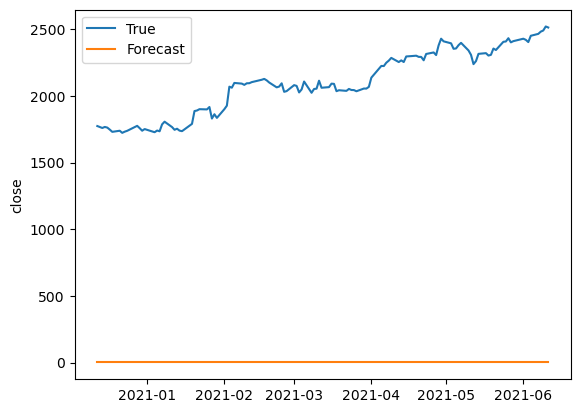

In [359]:
sns.lineplot(data=test[column_considered],label="True")
sns.lineplot(data=test['forecast'],label="Forecast")

Text(0.5, 1.0, 'Decomposizione modello moltiplicativo')

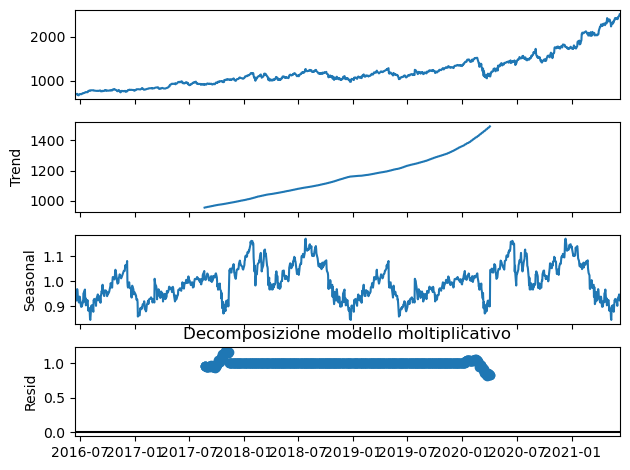

In [360]:
from statsmodels.tsa.seasonal import seasonal_decompose
seasonal_decompose(df_data,model='multiplicative',period=600).plot()
plt.title("Decomposizione modello moltiplicativo")

## Assumuiamo un modello moltiplicativo con un trend esponenziale e applichiamo un modello di regressione

In [361]:
# Trasformiamo il modello moltiplicativo in additivo
df_data[f'log_{column_considered}']=np.log(df_data[column_considered])

# Create dummified variables indicating the various seasons: as here we have an yearly seasonality, the seasons will be given by th various months.
# We drop the first dummy variable to avoid collinearity problems.
df_data['date_no']=df_data['date'].dt.month
month_vars=pd.get_dummies(df_data['Month_no'], drop_first=True,prefix='m').astype(int)

# concatenate the dummy columns to the original dataset and rename it df for regression: df_regr
df_regr = pd.concat([df_data,month_vars], axis=1)

# Add the time variable: here we consider the number of days from the first observation
df_regr['time']=df_regr['Month'].diff().dt.days.fillna(0).cumsum()

df_regr.head()

KeyError: 'date'

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition_plot_addi = seasonal_decompose(df_data[column_considered],model='addittive',period=1)
decomposition_plot_addi.plot()
plt.show()